In [1]:
print("hello")

hello


In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch import nn
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
from torchvision.transforms import functional as TF
from PIL import Image
import torchvision
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def show_images(loader):
    images, labels = next(iter(loader))
    grid_img = torchvision.utils.make_grid(images, nrow=8)
    plt.figure(figsize=(12, 12))
    plt.imshow(grid_img.permute(1, 2, 0).numpy())
    plt.axis('off')
    plt.show()



In [4]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split

# Define the transformations for STL-10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Load the STL-10 training dataset
trainset_full = torchvision.datasets.STL10(root='./data',  split='train+unlabeled', download=True, transform=transform)

# Split the training dataset into train and validation sets (80% train, 20% validation)
train_size = int(0.8 * len(trainset_full))
val_size = len(trainset_full) - train_size
trainset, valset = random_split(trainset_full, [train_size, val_size])

# Create DataLoader for the train set
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)

# Create DataLoader for the validation set
valloader = DataLoader(valset, batch_size=64, shuffle=False)

# Load the STL-10 test dataset
testset = torchvision.datasets.STL10(root='./data', split='test', download=True, transform=transform)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

# Example: Check the sizes of the datasets
print(f"Train set size: {train_size}")
print(f"Validation set size: {val_size}")
print(f"Test set size: {len(testset)}")



Files already downloaded and verified
Files already downloaded and verified
Train set size: 84000
Validation set size: 21000
Test set size: 8000


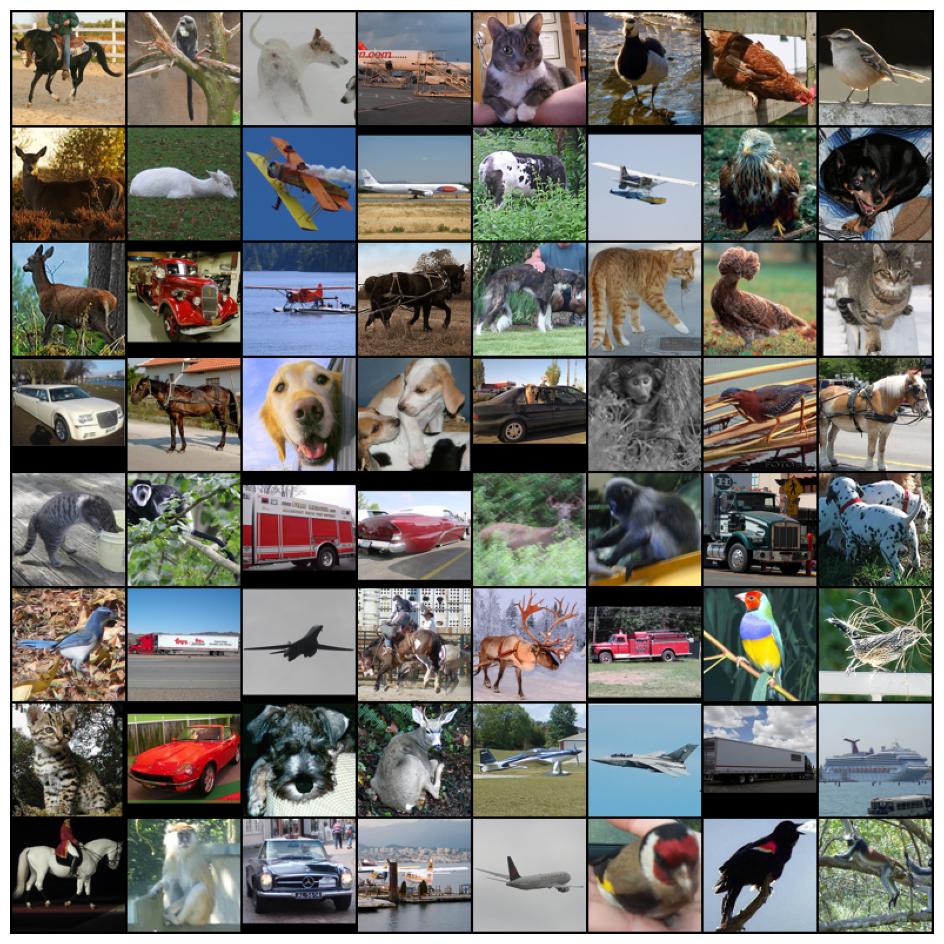

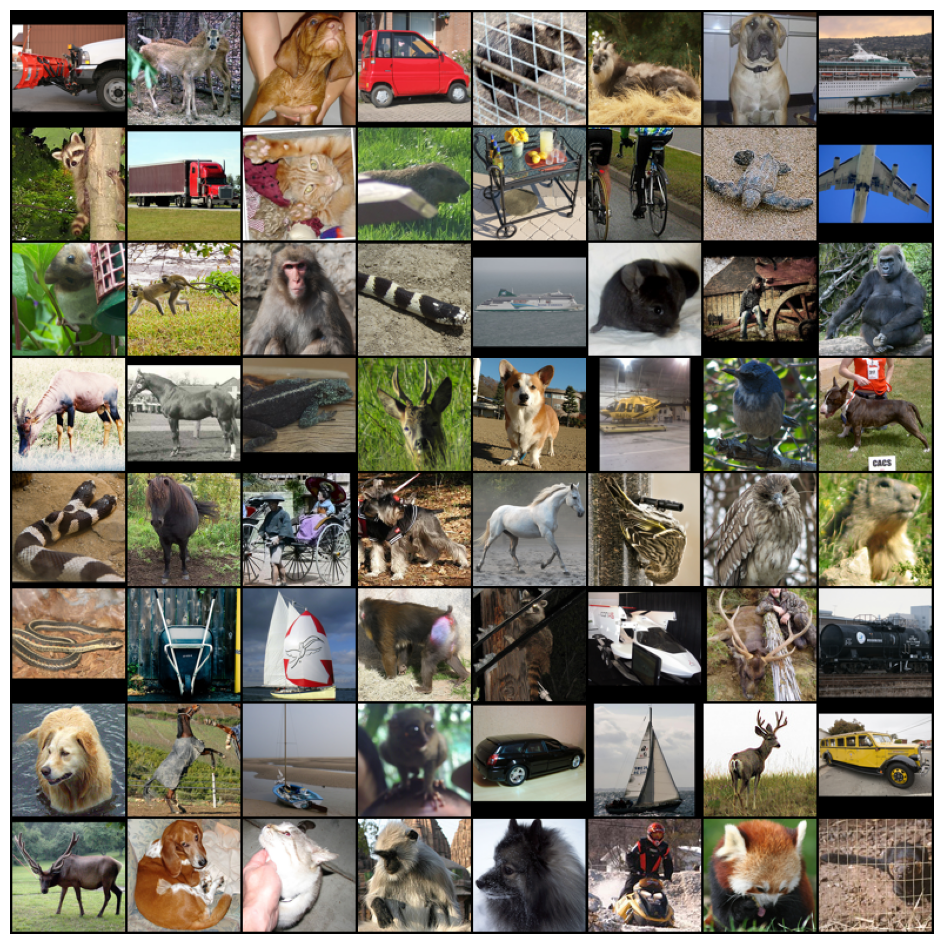

In [5]:
# Show images from the training set
show_images(testloader)
show_images(trainloader)

In [6]:
import random

class RotateDataset(torch.utils.data.Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
    
    def __getitem__(self, index):
        img, label = self.dataset[index]
        rotation_label = random.choice([0, 1, 2, 3])  # 0 = 0°, 1 = 90°, 2 = 180°, 3 = 270°
        img = transforms.functional.rotate(img, rotation_label * 90)
        return img, rotation_label  # Return rotated image and rotation label
    
    def __len__(self):
        return len(self.dataset)

# Use the RotateDataset to add rotation augmentation
rot_trainset = RotateDataset(trainset)
rot_trainloader = torch.utils.data.DataLoader(rot_trainset, batch_size=64, shuffle=True)


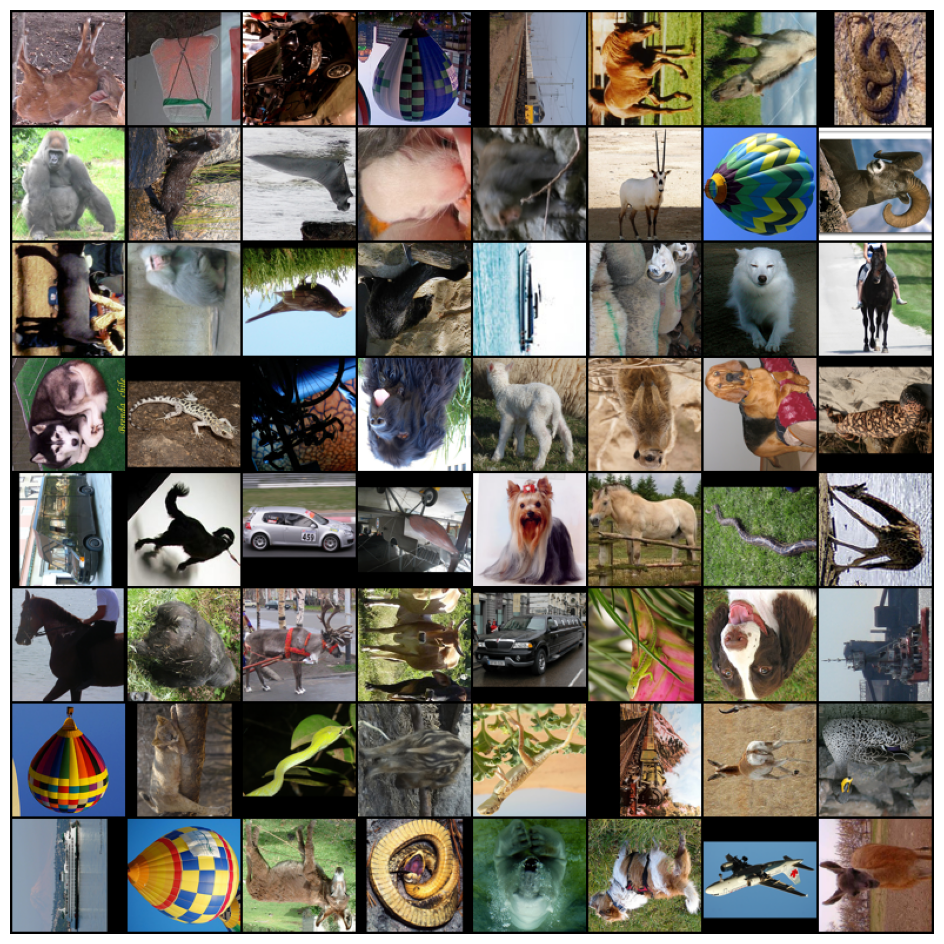

In [7]:
show_images(rot_trainloader)


In [8]:
import torch.nn as nn
import torchvision.models as models

# Define ResNetRotation model (ResNet18 for rotation classification task)
class ResNetRotation(nn.Module):
    def __init__(self):
        super(ResNetRotation, self).__init__()
        # Load ResNet18 backbone (without pre-trained weights)
        self.backbone = models.resnet18(weights=None)
        
        # Remove the last fully connected layer from ResNet18
        self.backbone = nn.Sequential(*list(self.backbone.children())[:-2])
        
        # Add a new fully connected layer for the 4 rotation classes
        num_ftrs = models.resnet18().fc.in_features  # Number of input features to the original fully connected layer
        self.fc = nn.Linear(num_ftrs, 4)  # 4 output classes: 0, 90, 180, 270 degrees

    def forward(self, x):
        # Pass the input through the backbone (feature extractor)
        x = self.backbone(x)
        
        # Global average pooling (after feature maps)
        x = nn.functional.adaptive_avg_pool2d(x, (1, 1))
        x = torch.flatten(x, 1)
        
        # Pass through the new fully connected layer
        x = self.fc(x)
        return x


In [9]:
# Create DataLoader for rotated datasets
rot_trainset = RotateDataset(trainset)
rot_valset = RotateDataset(valset)
rot_trainloader = DataLoader(rot_trainset, batch_size=64, shuffle=True)
rot_valloader = DataLoader(rot_valset, batch_size=64, shuffle=False)

# Initialize the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
rotation_model = ResNetRotation().to(device)

# Define the loss function (CrossEntropyLoss) and the optimizer (Adam)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(rotation_model.parameters(), lr=0.001)

# Prepare for training
num_epochs = 100  # Adjust epochs as needed
patience = 10
best_val_loss = float('inf')
patience_counter = 0
train_losses = []
val_losses = []

# Training loop
for epoch in range(num_epochs):
    # Training phase
    rotation_model.train()
    running_loss = 0.0
    for images, labels in rot_trainloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        # Forward pass
        outputs = rotation_model(images)

        # Compute loss (CrossEntropyLoss automatically applies softmax internally)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_loss = running_loss / len(rot_trainloader)
    train_losses.append(train_loss)

    # Validation phase
    rotation_model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for images, labels in rot_valloader:
            images, labels = images.to(device), labels.to(device)
            outputs = rotation_model(images)

            # Compute validation loss
            val_loss = criterion(outputs, labels)
            running_val_loss += val_loss.item()

    val_loss = running_val_loss / len(rot_valloader)
    val_losses.append(val_loss)

    print(f'Epoch {epoch + 1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        # Save the model
        torch.save(rotation_model.state_dict(), 'rotation_pretext_cross_entropy_model_2.pth')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

# Plot training and validation losses
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Function to show images
def show_images(loader):
    images, labels = next(iter(loader))
    grid_img = torchvision.utils.make_grid(images, nrow=8)
    plt.figure(figsize=(12, 12))
    plt.imshow(grid_img.permute(1, 2, 0).numpy())
    plt.axis('off')
    plt.show()

# Show some example images
show_images(rot_trainloader)

KeyboardInterrupt: 

In [9]:
# Initialize the ResNetRotation model and load the pretext task weights
rotation_model = ResNetRotation()
rotation_model.load_state_dict(torch.load('rotation_pretext_cross_entropy_model.pth'))


/tmp/ipykernel_281318/1769026826.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  rotation_model.load_state_dict(torch.load('rotation_pretext_cross_entropy_model.pth'))


<All keys matched successfully>

Files already downloaded and verified
Files already downloaded and verified


/tmp/ipykernel_281318/211783503.py:49: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  feature_extractor.load_state_dict(torch.load('rotation_pretext_cross_entropy_model.pth')

Epoch 1, Train Loss: 1.6965, Val Loss: 1.2811
Epoch 2, Train Loss: 0.9190, Val Loss: 1.0354
Epoch 3, Train Loss: 0.5390, Val Loss: 0.8254
Epoch 4, Train Loss: 0.2329, Val Loss: 0.9458
Epoch 5, Train Loss: 0.0746, Val Loss: 0.9876
Epoch 6, Train Loss: 0.0221, Val Loss: 1.0671
Epoch 7, Train Loss: 0.0286, Val Loss: 1.2732
Epoch 8, Train Loss: 0.0168, Val Loss: 1.2509
Epoch 9, Train Loss: 0.0228, Val Loss: 1.6228
Epoch 10, Train Loss: 0.0128, Val Loss: 1.3019
Epoch 11, Train Loss: 0.0176, Val Loss: 1.4560
Epoch 12, Train Loss: 0.0394, Val Loss: 1.6152
Epoch 13, Train Loss: 0.0314, Val Loss: 1.5520
Early stopping triggered.


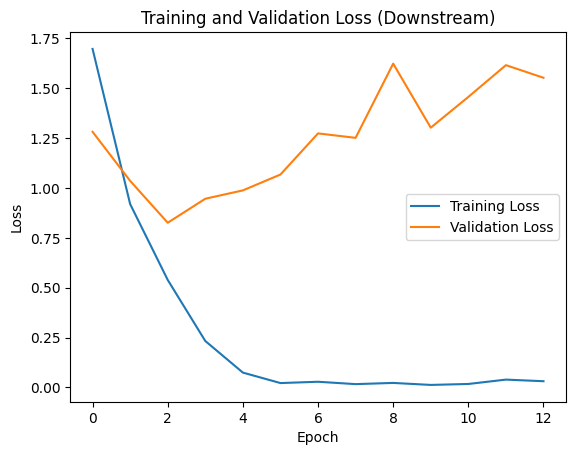

Validation Accuracy: 66.10%, Top-5 Accuracy: 95.30%


In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# Define the transform
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Load the STL-10 training dataset
trainset_full = torchvision.datasets.STL10(root='./data', split='train', download=True, transform=transform)

# Split the training dataset into train and validation sets (80% train, 20% validation)
train_size = int(0.8 * len(trainset_full))
val_size = len(trainset_full) - train_size
trainset, valset = random_split(trainset_full, [train_size, val_size])

# Create DataLoader for the train set
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)

# Create DataLoader for the validation set
valloader = DataLoader(valset, batch_size=64, shuffle=False)

# Load the STL-10 test dataset
testset = torchvision.datasets.STL10(root='./data', split='test', download=True, transform=transform)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

class DownstreamClassifier(nn.Module):
    def __init__(self, feature_extractor, num_classes=10):
        super(DownstreamClassifier, self).__init__()
        self.feature_extractor = feature_extractor
        self.classifier = nn.Linear(512, num_classes)  # Adjust input size based on your feature extractor output

    def forward(self, x):
        x = self.feature_extractor(x)  # Use feature extractor and update its weights
        x = nn.functional.adaptive_avg_pool2d(x, (1, 1))
        x = torch.flatten(x, 1)  # Flatten the features
        x = self.classifier(x)
        return x


# Initialize feature extractor and the downstream model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
feature_extractor = ResNetRotation().to(device)
feature_extractor.load_state_dict(torch.load('rotation_pretext_cross_entropy_model.pth'))
downstream_model = DownstreamClassifier(feature_extractor.backbone).to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(downstream_model.parameters(), lr=0.001)

# Prepare for fine-tuning
num_epochs = 150  # Adjust epochs as needed
train_losses = []
val_losses = []

# Early stopping parameters
patience = 10
best_val_loss = float('inf')
patience_counter = 0

# Training loop for downstream classification
for epoch in range(num_epochs):
    # Training phase
    downstream_model.train()
    running_loss = 0.0
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        # Forward pass
        outputs = downstream_model(images)

        # Compute loss
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_loss = running_loss / len(trainloader)
    train_losses.append(train_loss)

    # Validation phase
    downstream_model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for images, labels in valloader:
            images, labels = images.to(device), labels.to(device)
            outputs = downstream_model(images)

            # Compute validation loss
            val_loss = criterion(outputs, labels)
            running_val_loss += val_loss.item()

    val_loss = running_val_loss / len(valloader)
    val_losses.append(val_loss)

    print(f'Epoch {epoch + 1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        # Save the best model
        torch.save(downstream_model.state_dict(), 'best_downstream_classifier_model.pth')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

# Plot training and validation losses
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss (Downstream)')
plt.show()

# Function to evaluate the downstream classifier
def evaluate_model(model, loader):
    model.eval()
    correct = 0
    total = 0
    top5_correct = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Top-5 accuracy calculation
            top5_correct += (outputs.topk(5, dim=1).indices == labels.view(-1, 1)).sum().item()

    accuracy = correct / total
    top5_accuracy = top5_correct / total
    return accuracy, top5_accuracy

# Evaluate on validation set
val_accuracy, val_top5_accuracy = evaluate_model(downstream_model, valloader)
print(f'Validation Accuracy: {val_accuracy * 100:.2f}%, Top-5 Accuracy: {val_top5_accuracy * 100:.2f}%')

# Save the downstream model
torch.save(downstream_model.state_dict(), 'downstream_classifier_model.pth')
